<a href="https://colab.research.google.com/github/MMathisLab/DeepLabCut/blob/main/COLAB_Pytorch_SuperAnimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLabCut Model Zoo: SuperAnimal models

![alt text](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1616492373700-PGOAC72IOB6AUE47VTJX/ke17ZwdGBToddI8pDm48kB8JrdUaZR-OSkKLqWQPp_YUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYwL8IeDg6_3B-BRuF4nNrNcQkVuAT7tdErd0wQFEGFSnBqyW03PFN2MN6T6ry5cmXqqA9xITfsbVGDrg_goIDasRCalqV8R3606BuxERAtDaQ/modelzoo.png?format=1000w)

# 🦄 SuperAnimal in DeepLabCut PyTorch! 🔥

This notebook demos how to use our SuperAnimal models within DLC3. Please read more in [Ye et al. Nature Communications 2024](https://www.nature.com/articles/s41467-024-48792-2) about the available SuperAnimal models, and follow along below!

### **Let's get going: install DeepLabCut into COLAB:**

*Also, be sure you are connected to a GPU: go to menu, click Runtime > Change Runtime Type > select "GPU"*


In [ ]:
!pip install deeplabcut==3.0.0rc1

### PLEASE, click "restart runtime" from the output above before proceeding!

In [3]:
import deeplabcut
import os
from deeplabcut.pose_estimation_pytorch.apis.analyze_images import (
    superanimal_analyze_images,
)
from deeplabcut.core.weight_init import WeightInitialization
from deeplabcut.core.engine import Engine
from deeplabcut.modelzoo.video_inference import video_inference_superanimal
from deeplabcut.utils.pseudo_label import keypoint_matching



## Zero-shot Image Inference & Video Inference
SuperAnimal models are foundation animal pose models. They can be used for zero-shot predictions without further training on the data.
In this section, we show how to use SuperAnimal models to predict pose from images (given an image folder) and output the predicted images (with pose) into another dest folder.

## Zero-shot image inference

- If you have a single Image you want to test, upload it here!

#### Upload the images you want to predict

In [8]:
from google.colab import files

uploaded = files.upload()
for filepath, content in uploaded.items():
  print(f'User uploaded file "{filepath}" with length {len(content)} bytes')
image_path = os.path.abspath(filepath)
image_name = os.path.splitext(image_path)[0]

# If this cell fails (e.g., when using Safari in place of Google Chrome),
# manually upload your video via the Files menu to the left
# and define `video_path` yourself with right click > copy path on the video.

Saving zebra.png to zebra.png
User uploaded file "zebra.png" with length 1291107 bytes


### Select a SuperAnimal name and corresponding model architecture

Check Our Docs on [SuperAnimals](https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/ModelZoo.md) to learn more!

In [9]:
superanimal_name = 'superanimal_quadruped' # 'superanimal_topviewmouse', 'superanimal_quadruped'
model_name = 'hrnetw32'
max_individuals = 1 #how many animals do you expect to see?

In [11]:
# Note you need to enter max_individuals correctly to get the correct number of predictions in the image.
superanimal_analyze_images(superanimal_name,
                           model_name,
                           image_name,
                           max_individuals,
                           out_folder = '/content/')

Loading.... superanimal_quadruped_hrnetw32


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pose_model.pth:   0%|          | 0.00/160M [00:00<?, ?B/s]

detector.pt:   0%|          | 0.00/518M [00:00<?, ?B/s]

Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /usr/local/lib/python3.10/dist-packages/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw', 'belly_bottom', 'body_middle_right', 'body_middle_left']
start: None
stop: None
numframes2pick: None
skeleton: []
skeleton_color: black
pcutoff: None
dotsize: None
alphavalue: None
colormap: rainbow
Training

  0%|          | 0/1 [00:00<?, ?it/s]


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Zero-shot Video Inference
- Without Video adaptation (faster, but not self-supervised fine-tuned on your data!)

#### Upload a video you want to predict

In [12]:
from google.colab import files

uploaded = files.upload()
for filepath, content in uploaded.items():
  print(f'User uploaded file "{filepath}" with length {len(content)} bytes')
video_path = os.path.abspath(filepath)
video_name = os.path.splitext(video_path)[0]

# If this cell fails (e.g., when using Safari in place of Google Chrome),
# manually upload your video via the Files menu to the left
# and define `video_path` yourself with right click > copy path on the video.




Saving zebra-dancing.mov to zebra-dancing.mov
User uploaded file "zebra-dancing.mov" with length 21553881 bytes


#### Choose the superanimal and the model name

In [13]:
superanimal_name = 'superanimal_quadruped' # 'superanimal_topviewmouse', 'superanimal_quadruped'
model_name = 'hrnetw32'
max_individuals = 1 #how many animals do you expect to see?

### Zero-shot Video Inference without video adaptation

In [ ]:
video_inference_superanimal(
        videos=video_path,
        superanimal_name=f"{superanimal_name}_{model_name}",
        video_adapt=False,
        max_individuals=max_individuals,
        pseudo_threshold=0.1,
        bbox_threshold=0.9,
        detector_epochs=1,
        pose_epochs=1,
        dest_folder = '/content/')

running video inference on /content/zebra-dancing.mov with superanimal_quadruped_hrnetw32
Using pytorch for model hrnetw32
Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /usr/local/lib/python3.10/dist-packages/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw', 'belly_bottom', 'body_middle_right', 'body_middle_left']
start: None
stop: None
numf

 25%|██▌       | 116/458 [02:23<06:18,  1.11s/it]

### Zero-shot Video Inference with video adaptation (unsupervised)

In [ ]:
video_inference_superanimal(
        videos=video_path,
        superanimal_name=f"{superanimal_name}_{model_name}",
        video_adapt=True,
        max_individuals=max_individuals,
        pseudo_threshold=0.1,
        bbox_threshold=0.9,
        detector_epochs=1,
        pose_epochs=1,
        dest_folder = '/content/',
    )

running video inference on ['/content/uploaded_videos/dog-agility.mov'] with superanimal_quadruped_hrnetw32
Using pytorch for model hrnetw32
using /content/uploaded_videos/dog-agility.mov for video adaptation training
Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /content/drive/My Drive/DLCdev/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw'

 98%|█████████▊| 179/183 [03:43<00:04,  1.25s/it]


Running Pose Prediction


 98%|█████████▊| 179/183 [00:37<00:00,  4.80it/s]


Saving results to /content/processed_videos
Saving results in /content/processed_videos/dog-agility_superanimal_quadruped_hrnetw32.h5 and /content/processed_videos/dog-agility_superanimal_quadruped_hrnetw32_full.pickle
Duration of video [s]: 3.1, recorded with 59.03 fps!
Overall # of frames: 183 with cropped frame dimensions: 1128 630
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.18it/s] 


Video with predictions was saved as /content/processed_videos
Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /content/drive/My Drive/DLCdev/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw', 'belly_bottom', 'body_middle_right', 'body_middle_left']
start: None
stop: None
numframes2pick: None
skeleton: []
skeleton_color: black
pcutoff: None
dots

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 218MB/s]
/content/drive/My Drive/DLCdev/deeplabcut/pose_estimation_pytorch/data/transforms.py:68: UserWarning: Be careful! Do not train pose models with horizontal flips if you have symmetric keypoints!
  warnings.warn(
Data Transforms:
  Training:   Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': ['bbox_labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params={'format': 'xy', 'label_fields': ['class_labels'], 'remove_invisible': False, 'angle_in_degrees': True, 'check_each_transform': True}, additional_targets={}, 

model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

[timm/hrnet_w32.ms_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, inc

Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /content/drive/My Drive/DLCdev/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw', 'belly_bottom', 'body_middle_right', 'body_middle_left']
start: None
stop: None
numframes2pick: None
skeleton: []
skeleton_color: black
pcutoff: None
dotsize: None
alphavalue: None
colormap: rainbow
TrainingFraction:

 98%|█████████▊| 179/183 [02:29<00:03,  1.20it/s]


Running Pose Prediction


 98%|█████████▊| 179/183 [00:40<00:00,  4.39it/s]
The video metadata indicates that there 183 in the video, but only 179 were able to be processed. This can happen if the video is corrupted. You can try to fix the issue by re-encoding your video (tips on how to do that: https://deeplabcut.github.io/DeepLabCut/docs/recipes/io.html#tips-on-video-re-encoding-and-preprocessing)


Saving results to /content/processed_videos
Saving results in /content/processed_videos/dog-agility_superanimal_quadruped_hrnetw32.h5 and /content/processed_videos/dog-agility_superanimal_quadruped_hrnetw32_full.pickle
Duration of video [s]: 3.1, recorded with 59.03 fps!
Overall # of frames: 183 with cropped frame dimensions: 1128 630
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 83.19it/s]


Video with predictions was saved as /content/processed_videos


{'/content/uploaded_videos/dog-agility.mov': scorer      superanimal_quadruped_hrnetw32                                     \
 individuals                        animal0                                      
 bodyparts                             nose                          upper_jaw   
 coords                                   x           y likelihood           x   
 0                               564.648438  337.695312   0.878607  558.320312   
 1                               563.539062  336.867188   0.857735  557.242188   
 2                               439.617188  361.632812   0.829143  439.617188   
 3                               439.617188  362.632812   0.824444  439.617188   
 4                               652.023438  337.070312   0.388778  652.023438   
 ..                                     ...         ...        ...         ...   
 174                              -1.000000   -1.000000  -1.000000   -1.000000   
 175                              -1.000000   -1.00000

## Training with SuperAnimal
In this section, we compare different ways to train the model, using and without using SuperAnimal.
You can compare the evaluation results and get a sense of each baseline.
We have following baselines:

- ImageNet transfer learning (training without superanimal)
- SuperAnimal transfer learning (baseline 1)
- SuperAnimal naive fine-tuning (baseline 2)
- SuperAnimal memory-replay fine-tuning (baseline3)

#### Uploading your DLC project into Drive. Note you have to zip your DLC project and select the zipped file

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
    zip_file_path = os.path.join("/content", filename)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("/content/dlc_project_folder")

print("Contents of the extracted folder:")
extracted_files = os.listdir("/content/dlc_project_folder")
for file in extracted_files:
    print(f'- {file}')


Saving daniel3mouse.zip to daniel3mouse.zip
Contents of the extracted folder:
- __MACOSX
- daniel3mouse


#### Change the path to your project in dlc_project_folder

In [ ]:
dlc_proj_root = Path("/content/dlc_project_folder/daniel3mouse")

#### Comparison between different training baselines


Definition of data split: the unique combination of training images and testing images.
We create a data split named split 0. All baselines will share the data split to make fair comparisons.
- split 0 -> shared by all baselines
- shuffle 0 (split0) -> imagenet transfer learning
- shuffle 1 (split0) -> superanimal transfer learning
- shuffle 2 (split0) -> superanimal naive fine-tuning
- shuffle 3 (split0) -> superanimal memory-replay fine-tuning

### What is the difference between baselines?

**Transfer learning** For canonical task-agnostic transfer learning,
the encoder learns universal visual features from ImageNet, and a randomly
initialized decoder is used to learn the pose fromthe downstream dataset.

**Fine-tuning** For task aware
fine-tuning, both encoder and decoder learn task-related visual-pose features
in the pre-training datasets, and the decoder is fine-tuned to update pose
priors in downstream datasets. Crucially, the network has pose-estimation-specific
weights

**ImageNet transfer-learning** The encoder was pre-trained from ImageNet. The decoder is trained from scratch in the downstream tasks

**SuperAnimal transfer-learning** The encoder was pre-trained first from ImageNet, then in pose datasets we colleceted. Then decoder is trained from scratch in downstream tasks.

**SuperAnimal naive fine-tuning** Both the encoder and the decoder were pre-trained in pose datasets we collected. In downstream datsets, we only finetune convolutional channels that correspond to the annotated keypoints in the downstream datasets. This introduces catastrophic forgetting in keypoints that are not annotated in the downstream datasets.

**SuperAnimal memory-replay fine-tuning** If we apply fine-tuning with SuperAnimal without further cares, the models will forget about keypoints that are not annotated in the downstream datasets. To mitigate this, we mix the annotations and zero-shot predictions of SuperAnimal models to create a dataset that 'replays' the memory of the SuperAnimal keypoints.




In [ ]:
imagenet_transfer_learning_shuffle = 0
superanimal_transfer_learning_shuffle = 1
superanimal_naive_finetune_shuffle = 2
superanimal_memory_replay_shuffle = 3

In [ ]:
config_path = dlc_proj_root / 'config.yaml'
deeplabcut.create_training_dataset(
    config_path,
    Shuffles = [imagenet_transfer_learning_shuffle],
    net_type="top_down_hrnet_w32",
    engine=Engine.PYTORCH,
    userfeedback=False,
)

Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
Creating training data for: Shuffle: 0 TrainFraction:  0.95


100%|██████████| 152/152 [00:00<00:00, 3254.90it/s]


The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


### ImageNet transfer learning

Historically, the transfer learning using ImageNet weights strategies assumed no “animal pose task priors” in the pretrained
model, a paradigm adopted from previous task-agnostic transfer learning.

In [ ]:
# Note we skip the detector training to save time. The evaluation is by default using ground-truth bounding box.
# But to train a model that can be used to inference videos and images, you have to set detector_epochs > 0
deeplabcut.train_network(config_path, detector_epochs = 0, epochs = 3, save_epochs = 3, batch_size = 64, shuffle = imagenet_transfer_learning_shuffle)

Training with configuration:
data:
  colormode: RGB
  inference:
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [1.0, 1.0]
      translation: 0
    collate: None
    covering: False
    gaussian_noise: 12.75
    hist_eq: False
    motion_blur: False
    normalize_images: True
detector:
  data:
    colormode: RGB
    inference:
      normalize_images: True
    train:
      affine:
        p: 0.5
        rotation: 30
        scaling: [1.0, 1.0]
        translation: 40
      collate:
        type: ResizeFromDataSizeCollate
        min_scale: 0.4
        max_scale: 1.0
        min_short_side: 128
        max_short_side: 1152
        multiple_of: 32
        to_square: False
      hflip: True
      normalize_images: True
  device: auto
  model:
    type: FasterRCNN
    freeze_bn_stats: True
    freeze_bn_weights: False
    variant: fasterrcnn_mobilenet_v3_large_fpn
  run

#### Though the evaluation was also done during training, let's just do it again here to double-check

In [ ]:
deeplabcut.evaluate_network(config_path, Shuffles = [imagenet_transfer_learning_shuffle])

INFO:root:Using GT bounding boxes to compute evaluation metrics
100%|██████████| 9/9 [00:04<00:00,  1.86it/s]
INFO:root:Evaluation results for DLC_HrnetW32_MultiMouseDec16shuffle0_snapshot_001-results.csv (pcutoff: 0.01):
INFO:root:train rmse            54.74
train rmse_pcutoff    54.74
train mAP              0.58
train mAR              3.46
train mAP_pcutoff      0.58
train mAR_pcutoff      3.46
test rmse             55.73
test rmse_pcutoff     55.73
test mAP               2.78
test mAR               7.04
test mAP_pcutoff       2.78
test mAR_pcutoff       7.04
Name: (0.95, 0, 1, -1, 0.01), dtype: float64


### Transfer learning with SuperAnimal weights

#### Prepare training shuffle for transfer-learning with SuperAnimal weights

In [ ]:
weight_init = WeightInitialization(
    dataset=f"{superanimal_name}",
    with_decoder=False,
)

deeplabcut.create_training_dataset_from_existing_split(config_path,
                                                        from_shuffle = imagenet_transfer_learning_shuffle,
                                                        shuffles = [superanimal_transfer_learning_shuffle],
                                                        engine = Engine.PYTORCH,
                                                        net_type="top_down_hrnet_w32",
                                                        weight_init = weight_init,
                                                        userfeedback = False)




Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
You passed a split with the following fraction: 94%
Creating training data for: Shuffle: 1 TrainFraction:  0.94


100%|██████████| 152/152 [00:00<00:00, 7673.55it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


#### Launch the training for transfer-learning with SuperAnimal weights

In [ ]:
deeplabcut.train_network(config_path, detector_epochs = 0, epochs = 3, batch_size = 64, shuffle = superanimal_transfer_learning_shuffle)

Training with configuration:
data:
  colormode: RGB
  inference:
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [1.0, 1.0]
      translation: 0
    collate: None
    covering: False
    gaussian_noise: 12.75
    hist_eq: False
    motion_blur: False
    normalize_images: True
detector:
  data:
    colormode: RGB
    inference:
      normalize_images: True
    train:
      affine:
        p: 0.5
        rotation: 30
        scaling: [1.0, 1.0]
        translation: 40
      collate:
        type: ResizeFromDataSizeCollate
        min_scale: 0.4
        max_scale: 1.0
        min_short_side: 128
        max_short_side: 1152
        multiple_of: 32
        to_square: False
      hflip: True
      normalize_images: True
  device: auto
  model:
    type: FasterRCNN
    freeze_bn_stats: False
    freeze_bn_weights: False
    variant: fasterrcnn_mobilenet_v3_large_fpn
  ru

#### Evaluate the model obtained by transfer-learning with SuperAnimal weights

In [ ]:
deeplabcut.evaluate_network(config_path, Shuffles = [superanimal_transfer_learning_shuffle])

INFO:root:Using GT bounding boxes to compute evaluation metrics
100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
INFO:root:Evaluation results for DLC_HrnetW32_MultiMouseDec16shuffle1_snapshot_003-results.csv (pcutoff: 0.01):
INFO:root:train rmse            34.03
train rmse_pcutoff    34.03
train mAP             21.50
train mAR             27.52
train mAP_pcutoff     21.50
train mAR_pcutoff     27.52
test rmse             34.55
test rmse_pcutoff     34.55
test mAP              22.24
test mAR              28.15
test mAP_pcutoff      22.24
test mAR_pcutoff      28.15
Name: (0.94, 1, 3, -1, 0.01), dtype: float64


### Fine-tuning with SuperAnimal (without keeping full SuperAnimal keypoints)

#### Setup the weight init and dataset
First we do keypoint matching. This steps make it possible to understand the correspondance between the existing annotations and SuperAnimal annotations. This step produces 3 outputs
- The confusion matrix
- The conversion table
- Pseudo predictions over the whole dataset

#### What is keypoint matching?

Because SuperAnimal models have their pre-defined keypoints that are potentially different from your annotations, we porposed this algorithm to minimize the gap between the model and the dataset. We use our model to perform zero-shot inference on the whole dataset. This gives pairs of predictions and ground truth for every image. Then, we cast the matching between models’ predictions (2D coordinates)
and ground truth as bipartitematching using the Euclidean distance as the cost between paired of keypoints. We then solve the matching using the Hungarian algorithm. Thus for every image, we end up getting a matching matrix where 1 counts formatch and 0 counts for non-matching. Because the models’ predictions can be noisy from image to image, we average the aforementioned matching matrix across all the images and perform another bipartite matching, resulting in the final keypoint conversion table between the model and the dataset. Note that the quality of thematching will impact the performance
of the model, especially for zero-shot. In the case where, e.g., the annotation nose is mistakenly converted to keypoint tail and vice versa, the model will have to unlearn the channel that corresponds to nose and tail (see also case study in Mathis et al.).

Before checking trainset temp_dataset
Before checking testset temp_dataset
Task: None
scorer: None
date: None
multianimalproject: None
identity: None
project_path: /content/drive/My Drive/DLCdev/deeplabcut/modelzoo/project_configs
engine: pytorch
video_sets: None
bodyparts: ['nose', 'upper_jaw', 'lower_jaw', 'mouth_end_right', 'mouth_end_left', 'right_eye', 'right_earbase', 'right_earend', 'right_antler_base', 'right_antler_end', 'left_eye', 'left_earbase', 'left_earend', 'left_antler_base', 'left_antler_end', 'neck_base', 'neck_end', 'throat_base', 'throat_end', 'back_base', 'back_end', 'back_middle', 'tail_base', 'tail_end', 'front_left_thai', 'front_left_knee', 'front_left_paw', 'front_right_thai', 'front_right_knee', 'front_right_paw', 'back_left_paw', 'back_left_thai', 'back_right_thai', 'back_left_knee', 'back_right_knee', 'back_right_paw', 'belly_bottom', 'body_middle_right', 'body_middle_left']
start: None
stop: None
numframes2pick: None
skeleton: []
skeleton_color: black
pcuto

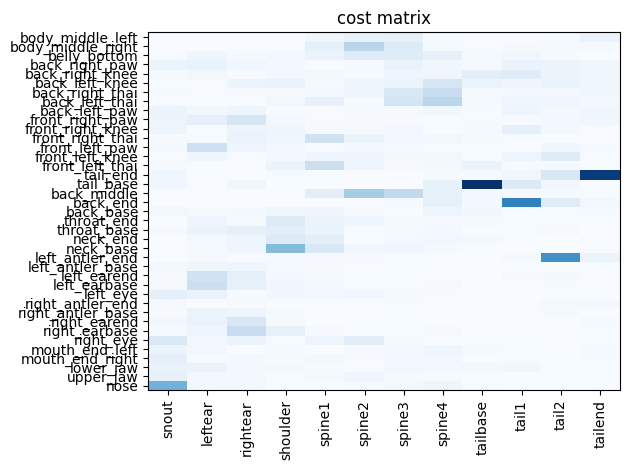

In [ ]:
keypoint_matching(
    config_path,
    superanimal_name,
    model_name,
)

conversion_table_path = dlc_proj_root / "memory_replay" / "conversion_table.csv"
confusion_matrix_path = dlc_proj_root / "memory_replay" / "confusion_matrix.png"
# You can visualize the pseudo predictions, or do pose embedding clustering etc.
pseudo_prediction_path = dlc_proj_root / "memory_replay" / "pseudo_predictions.json"

#### Display the confusion matrix

The x axis lists the keypoints in the existing annotations. The y axis lists the keypoints in SuperAnimal keypoint space. Darker color encodes stronger correspondance between the human annotation and SuperAnimal annotations.

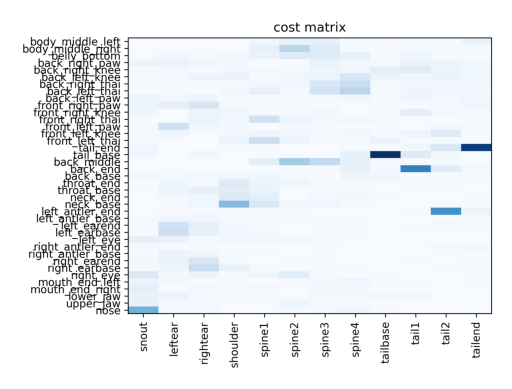

In [ ]:

confusion_matrix_image = mpimg.imread(confusion_matrix_path)
plt.imshow(confusion_matrix_image)
plt.axis('off')  # Hide the axes for better view
plt.show()

#### Display the conversion table
The gt columns represents the keypoint names in the existing dataset. The MasterName represents the correspoinding keypoints in SuperAnimal keypoint space.

In [ ]:
import pandas as pd
df = pd.read_csv(conversion_table_path)
df = df.dropna()
print (df)

          gt          MasterName
0      snout                nose
6   rightear       right_earbase
11   leftear        left_earbase
14     tail2     left_antler_end
15  shoulder           neck_base
20     tail1            back_end
21    spine3         back_middle
22  tailbase           tail_base
23   tailend            tail_end
24    spine1     front_left_thai
31    spine4      back_left_thai
37    spine2   body_middle_right


#### Prepare the training shuffle and weight initialization for (naive) fine-tuning with SuperAnimal weights

In [ ]:
from deeplabcut.modelzoo.utils import (
    create_conversion_table,
    read_conversion_table_from_csv,
)
table = create_conversion_table(
        config=config_path,
        super_animal=superanimal_name,
        project_to_super_animal=read_conversion_table_from_csv(conversion_table_path),
)

weight_init = WeightInitialization(
    dataset=superanimal_name,
    with_decoder=True,
    conversion_array=table.to_array()
)

deeplabcut.create_training_dataset_from_existing_split(config_path,
                                                        from_shuffle = imagenet_transfer_learning_shuffle,
                                                        shuffles = [superanimal_naive_finetune_shuffle],
                                                        engine = Engine.PYTORCH,
                                                        net_type="top_down_hrnet_w32",
                                                        weight_init = weight_init,
                                                        userfeedback = False)


Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
You passed a split with the following fraction: 94%
Creating training data for: Shuffle: 2 TrainFraction:  0.94


100%|██████████| 152/152 [00:00<00:00, 12111.90it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


#### Launch the training for (naive) fine-tuning with SuperAnimal

In [ ]:
deeplabcut.train_network(config_path, detector_epochs = 0, epochs = 3, save_epochs = 3, eval_interval = 1, batch_size = 64, shuffle = superanimal_naive_finetune_shuffle)

Training with configuration:
data:
  colormode: RGB
  inference:
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
    normalize_images: True
  train:
    affine:
      p: 0.5
      scaling: [1.0, 1.0]
      rotation: 30
      translation: 0
    gaussian_noise: 12.75
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
detector:
  data:
    colormode: RGB
    inference:
      normalize_images: True
    train:
      hflip: True
      normalize_images: True
  device: auto
  model:
    type: FasterRCNN
    variant: fasterrcnn_resnet50_fpn_v2
    box_score_thresh: 0.6
    pretrained: False
  runner:
    type: DetectorTrainingRunner
    eval_interval: 50
    optimizer:
      type: AdamW
      params:
        lr: 1e-05
    scheduler:
      type: LRListScheduler
      params:
        milestones: [90]
        lr_list: [[1e-06]]
    snapshots:
      max_snapshots: 5
      save_epochs: 50
      save_optimizer_state: False


#### Evaluate the model obtained by (naive) fine-tuning with SuperAnimal

In [ ]:
deeplabcut.evaluate_network(config_path, Shuffles = [superanimal_naive_finetune_shuffle])

INFO:root:Using GT bounding boxes to compute evaluation metrics
100%|██████████| 9/9 [00:04<00:00,  1.84it/s]
INFO:root:Evaluation results for DLC_HrnetW32_MultiMouseDec16shuffle2_snapshot_003-results.csv (pcutoff: 0.01):
INFO:root:train rmse            48.46
train rmse_pcutoff    47.76
train mAP             10.08
train mAR             21.36
train mAP_pcutoff     10.07
train mAR_pcutoff     21.29
test rmse             47.00
test rmse_pcutoff     46.74
test mAP              12.16
test mAR              22.22
test mAP_pcutoff      12.16
test mAR_pcutoff      22.22
Name: (0.94, 2, 3, -1, 0.01), dtype: float64


## Memory-replay fine-tuning with SuperAnimal (keeping full SuperAnimal keypoints)

**Catastrophic forgetting** describes a
classic problemin continual learning. Indeed, amodel gradually loses
its ability to solve previous tasks after it learns to solve new ones.
Fine-tuning a SuperAnimal models falls into the category of continual
learning: the downstream dataset defines potentially different
keypoints than those learned by the models. Thus, the models might
forget the keypoints they learned and only pick up those defined in the
target dataset. Here, retraining with the original dataset and the new
one, is not a feasible option as datasets cannot be easily shared and
more computational resources would be required.
To counter that, we treat zero-shot inference of the model as a
memory buffer that stores knowledge from the original model. When
we fine-tune a SuperAnimal model, we replace the model predicted
keypoints with the ground-truth annotations, resulting in hybrid
learning of old and new knowledge. The quality of the zero-shot predictions
can vary and we use the confidence of prediction (0.7) as a
threshold to filter out low-confidence predictions. With the threshold
set to 1, memory replay fine-tuning becomes naive-fine-tuning.

#### Prepare training shuffle and weight initialization for memory-replay finetuning with SuperAnimal

In [ ]:
weight_init = WeightInitialization(
    dataset=superanimal_name,
    conversion_array=table.to_array(),
    with_decoder=True,
    memory_replay=True,
)

deeplabcut.create_training_dataset_from_existing_split(config_path,
                                                        from_shuffle = imagenet_transfer_learning_shuffle,
                                                        shuffles = [superanimal_memory_replay_shuffle],
                                                        engine = Engine.PYTORCH,
                                                        net_type="top_down_hrnet_w32",
                                                        weight_init = weight_init,
                                                        userfeedback = False)


Utilizing the following graph: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [8, 10], [8, 11], [9, 10], [9, 11], [10, 11]]
You passed a split with the following fraction: 94%
Creating training data for: Shuffle: 3 TrainFraction:  0.94


100%|██████████| 152/152 [00:00<00:00, 11984.40it/s]

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


#### Launch the training for memory-replay fine-tuning with SuperAnimal

In [ ]:
deeplabcut.train_network(config_path, detector_epochs = 0, epochs = 3, save_epochs = 3, eval_interval = 1, batch_size = 64, shuffle = superanimal_naive_finetune_shuffle)

Training with configuration:
data:
  colormode: RGB
  inference:
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
    normalize_images: True
  train:
    affine:
      p: 0.5
      scaling: [1.0, 1.0]
      rotation: 30
      translation: 0
    gaussian_noise: 12.75
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
detector:
  data:
    colormode: RGB
    inference:
      normalize_images: True
    train:
      hflip: True
      normalize_images: True
  device: auto
  model:
    type: FasterRCNN
    variant: fasterrcnn_resnet50_fpn_v2
    box_score_thresh: 0.6
    pretrained: False
  runner:
    type: DetectorTrainingRunner
    eval_interval: 50
    optimizer:
      type: AdamW
      params:
        lr: 1e-05
    scheduler:
      type: LRListScheduler
      params:
        milestones: [90]
        lr_list: [[1e-06]]
    snapshots:
      max_snapshots: 5
      save_epochs: 50
      save_optimizer_state: False


#### Evaluate the model obtained by memory-replay finetuning with SuperAnimal

In [ ]:
deeplabcut.evaluate_network(config_path, Shuffles = [superanimal_memory_replay_shuffle])